<span class='main_title'>Unstructured Data I Project</span>
<hr>
<span class='author'>author:<a href='github.com/baiochi'>@baiochi<span>

**Description**  
Create a solution with <a href='https://google.github.io/mediapipe/'>`MediaPipe`</a> library for detect Sign language through a Webcam.  

# Notebook Setup

## Aesthetics

In [153]:
# Terminal ASCII colors
WHITE = '\033[39m'
CYAN  = '\033[36m'
GREEN = '\033[32m'

# Image drawing colors
BLUE   = '#00fafd'    # rgb(0,250,253)
YELLOW = '#f5b324'    # rgb(245,179,36)

# Display images in Jupyter Notebook
from IPython.display import Image

# Styling notebook with CSS
from IPython.core.display import HTML
styles = open("./styles/custom.css", "r").read()
HTML(styles)

## Libraries

In [359]:
# Supress warnings
import warnings; warnings.filterwarnings('ignore')

# Data and math operations
import re
from math import hypot, atan2, degrees
import numpy as np
import pandas as pd

# Compute DTW distance
from scipy.spatial.distance import euclidean
from scipy.stats import uniform
from fastdtw import fastdtw

# Image processing
import cv2
import mediapipe as mp

# Image visualizations
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go

# Audio Speech
import pyttsx3

# For opening images via URL
from PIL.Image import open as open_image
from urllib.request import urlopen

# Read mediapipe labels
from google.protobuf.json_format import MessageToDict

# OS functions
import os
import time

# Load binary
import pickle

# Docstrings
from typing import List

# Progress bar
from tqdm.auto import tqdm

## Mediapipe Setup

In [155]:
# Mediapipe instances
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# Landmark styles
HAND_CONNECTIONS = mp_hands.HAND_CONNECTIONS
# DEFAULT_LANDMARK_POINTS = mp_drawing_styles.get_default_hand_landmarks_style()
# DEFAULT_LANDMARK_CONNECTIONS = mp_drawing_styles.get_default_hand_connections_style()
LANDMARK_DRAWING_SPECS = mp_drawing.DrawingSpec(
        color=(36, 179, 245), 
        thickness=1, 
        circle_radius=4
)
CONNECTIONS_DRAWING_SPECS=mp_drawing.DrawingSpec(
        color=(253, 250, 0), 
        thickness=2, 
        circle_radius=5
)
FONT_ARGS = {
    'fontFace'  : cv2.FONT_HERSHEY_SIMPLEX,
    'fontScale' : 1,
    'color'     : (253, 250, 0),
    'thickness' : 2,
    'lineType'  : cv2.LINE_AA
}
LETTER_ARGS = {
    'fontFace'  : cv2.FONT_HERSHEY_SIMPLEX,
    'fontScale' : 3,
    'color'     : (0, 250, 253),
    'thickness' : 2,
    'lineType'  : cv2.LINE_AA
}

In [156]:
# Mapping of handpoints
_hand_point_names = [ 
                     ['THUMB_'         + i for i in ['CMC','MCP','IP','TIP']],
                     ['INDEX_FINGER_'  + i for i in ['MCP','PIP','DIP','TIP']],
                     ['MIDDLE_FINGER_' + i for i in ['MCP','PIP','DIP','TIP']],
                     ['RING_FINGER_'   + i for i in ['MCP','PIP','DIP','TIP']],
                     ['PINKY_'         + i for i in ['MCP','PIP','DIP','TIP']]
                    ]
_hand_point_names  = ['WRIST'] + [value for sublist in _hand_point_names for value in sublist]

HAND_POINT_MAPPING = {index:_hand_point_names[index] for index in range(21)}

def create_mapping(landmark_results:list) -> dict:
    '''
    Map every position with the respective name
    Example: 0 -> 'WRIST'; 1 -> 'THUMB_CMC' etc
    '''
    _hand_coord = [([i[1], i[2]]) for i in landmark_results]
    hand_map = {
        HAND_POINT_MAPPING[index]: coord for index, coord in enumerate(_hand_coord)}
    return hand_map

Image(url= 'https://google.github.io/mediapipe/images/mobile/hand_landmarks.png', width=600, height=400)

#  Sign Detection Workflow

## Capturing frames with Webcam

In [158]:
def capture_gesture(FRAME_SIZE=60):
    # Create Mediapipe Hands model
    hands = mp_hands.Hands(model_complexity=0, 
                           min_detection_confidence=0.5, 
                           min_tracking_confidence=0.9)
    # Store frames/results
    frame_list = []
    results_list = []

    # Settings
    recording = False

    # Webcam input
    cam = cv2.VideoCapture(0)

    while cam.isOpened():
        # Read frame
        _, image = cam.read()

        # Improve performance -> False
        image.flags.writeable = False
        # Convert image from BGR to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Detect hands
        results = hands.process(rgb_image)

        # Start "recording"
        if recording:
            # Recording flag
            cv2.putText(image, 'Recording...', (30, 50), **FONT_ARGS)

            if len(frame_list) < FRAME_SIZE:
                frame_list.append(image)
                results_list.append(results)
            else:
                print('Ending recording...')
                recording = False

        # Show image
        cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
        # Key control
        pressed_key = cv2.waitKey(1) & 0xFF
        # Start recording
        if pressed_key == ord('r'):
            recording = True
        # Close webcam
        elif pressed_key == ord('q'):
            recording = False
            break

    # Release video capture
    cam.release()
    # Memory dump
    cv2.destroyAllWindows()
    # fix window not closing bug on macOS 10.15
    cv2.waitKey(1)
    
    return frame_list, results_list

In [159]:
frame_list, results_list = capture_gesture()

Ending recording...


## Draw hand landmarks

In [160]:
def draw_frame_landmarks(frame_list, results_list):
    annot_images = frame_list.copy()

    for frame_number, results in enumerate(results_list):
        if results.multi_hand_landmarks:
            for hand_number, hand_landmark in enumerate(results.multi_hand_landmarks):
                # Draw annotations
                mp_drawing.draw_landmarks(
                            annot_images[frame_number],
                            hand_landmark,
                            HAND_CONNECTIONS,
                            LANDMARK_DRAWING_SPECS,
                            CONNECTIONS_DRAWING_SPECS)
    return annot_images

In [161]:
annot_images = draw_frame_landmarks(frame_list, results_list)

## Plot frames with landmarks

In [ ]:
def plot_frames(annot_images):
    fig = plt.figure(figsize=(16,12))
    plt.axis('off')
    plt.title('Example of frames record', size=18, pad=20, loc='left')
    for i, image in enumerate(annot_images[::3]):
        if i == 9:
            break
        fig.add_subplot(3, 3, i+1)
        plt.title(f'Frame {i*3}')
        plt.axis('off')
        # Convert color since matplotlib uses RGB
        plt.imshow(cv2.flip(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1));
        

In [ ]:
plot_frames(annot_images)

## Process results

**results_list**: contains *mediapipe.python.solution_base.SolutionOutputs*  
> **multi_hand_landmarks**: list of detected hands, 'Right' or 'Left'  
>> **hand_landmark**: list of every node coordinates(x,y,z)  
>>> **landmark**: x,y,z coordinates for the current node

### Store landmark coordinates in `pd.DataFrame`

In [163]:
def process_results(results_list, verbose=False):
    # Store mapping for each hand
    left_hand_list = []
    right_hand_list = []

    # Iterate over results
    for frame_number, results in enumerate(results_list):
        # Check if any hand was detected
        if results.multi_hand_landmarks:

            # Iterate over hands (right or left)
            for hand_number, hand_landmark in enumerate(results.multi_hand_landmarks):

                # Extract hand orientation str
                hand_label = MessageToDict(results.multi_handedness[hand_number])
                hand_label = hand_label['classification'][0]['label']

                # Create dataframe to store node coordinates
                hand_map_df = pd.DataFrame()

                # Iterate over landmarks of current hand
                for node_id, landmark in enumerate(hand_landmark.landmark):
                    # Get coordinates and labels
                    _row = pd.DataFrame(
                            data={
                                'x'          : landmark.x,
                                'y'          : landmark.y,
                                'z'          : landmark.z,
                            }, index=[node_id])
                    # Append row to dataframe
                    hand_map_df = pd.concat([hand_map_df, _row])

                # Add mapping for into the corresponding hand
                if hand_label == 'Left':
                    left_hand_list.append(hand_map_df)
                elif hand_label == 'Right':
                    right_hand_list.append(hand_map_df)
        #print(f'Frame {frame_number}, Left={len(left_hand_list)}, Right={len(right_hand_list)}')
    if verbose:
        print(f'Frames detected:\nLeft hand:{len(left_hand_list)}, Right hand:{len(right_hand_list)}')
    
    return left_hand_list, right_hand_list

In [164]:
left_hand_list, right_hand_list = process_results(results_list, verbose=True)

Frames detected:
Left hand:59, Right hand:1


*Obs:* Some frames can detect the same hand twice.

Visualizing `hand_map_df`

In [165]:
left_hand_list[0].head()

,x,y,z
0,0.316803,0.815947,-8.183841e-09
1,0.375296,0.799240,-1.077831e-02
2,0.429680,0.721541,-1.698737e-02
3,0.450280,0.641959,-2.677812e-02
4,0.438838,0.569477,-3.288167e-02


### Calculate hand_landmark angles

**hand_map_df**: dataframe with all landmarks coordinates for a frame  
> **create_hand_gesture**: iterate over a frame_list to get angle for every landmark    
>> **calculate_finger_distances**: distance between wrist node and finger tip.   
>> **get_landmark_angles**: iterate over a hand_map_df to calculate angles  
>>> **calculate_3D_angle**: calculate the angle between 2 nodes of 3 dimensions  


In [395]:
def calculate_finger_distances(landmark:pd.DataFrame) -> List[float]:
    '''
    Calculate the distance between Wrist node and all fingertips.  
    frame_list: pd.Dataframe containing landmark coordinates  
    Return: list of floats
    '''
    finger_distances = []
    
    for index in [4,8,12,16,20]:
        # Wrist node
        p1 = left_hand_list[0].iloc[0,:].values
        # Fingertip node
        p2 = left_hand_list[0].iloc[index,:].values
        # Calculate distance
        squared_dist = np.sum((p1-p2)**2, axis=0)
        dist = np.sqrt(squared_dist)
        finger_distances.append(dist)
    
    return finger_distances

In [166]:
def calculate_3D_angle(u:np.ndarray, v:np.ndarray) -> float:
    '''
    Calculate the angle between 2 points with (x,y,z) coordinates
    ang = acos( (x1*x2 + y1*y2 + z1*z2) / sqrt( (x1*x1 + y1*y1 + z1*z1)*(x2*x2+y2*y2+z2*z2) ) )
    Return: angle in radians
    '''
    # Calculate cross product
    dot_product = np.dot(u, v)
    # Calculate vector norm
    norm = np.linalg.norm(u) * np.linalg.norm(v)
    # Calculate angle in radians
    angle = np.arccos(dot_product / norm)
    if np.isnan(angle) or np.isinf(angle):
        angle=0
    return angle

In [167]:
def get_landmark_angles(landmark_df:pd.DataFrame) -> np.ndarray:
    '''
    Dataframe format:
    x	y	z
    0.183309	0.889030	9.577590e-09
    Return: list of shape 441
    '''
    landmark_angles = []
    # Multiply every node with each other, 21 connections * 21 = 441 angles
    for i in range(landmark_df.shape[0]):
        for j in range(landmark_df.shape[0]):
            # Calculate angle between X and Y coordinates
            _node_1 = landmark_df.iloc[i,[1,2]]
            _node_2 = landmark_df.iloc[j,[1,2]]
            landmark_angles.append(calculate_3D_angle(_node_1, _node_2))
    return landmark_angles

In [396]:
def create_hand_gesture(frame_list:list, connections=441, hand_label=''):
    '''
    frame_list: list of pd.Dataframe containing landmark coordinates
    connections(int): number of connected nodes
    Return: array of shape(frame_number, connections) to compute distance
    '''
    frame_size = len(frame_list)
    
    # Create empty dict/arrays
    distance_array = np.zeros([frame_size, 5])
    gesture_array = np.zeros([frame_size, connections])
    
    for frame_index, landmark in tqdm(enumerate(frame_list), 
                                      desc=f'Calculating {hand_label} landmark angles/distances',
                                      total=frame_size,
                                      colour='#00fafd'):
        # Compute finger distances
        distance_array[frame_index] = calculate_finger_distances(landmark)
        # Compute angles for each landmark
        gesture_array[frame_index] = get_landmark_angles(landmark)
        
    return gesture_array, distance_array

Calculate angles for each hand:

In [397]:
left_hand_gesture, left_hand_distance  = create_hand_gesture(left_hand_list, hand_label='left')
right_hand_gesture, right_hand_distance = create_hand_gesture(right_hand_list, hand_label='right')

Calculating left landmark angles/distances:   0%|          | 0/59 [00:00<?, ?it/s]

Calculating right landmark angles/distances:   0%|          | 0/1 [00:00<?, ?it/s]

## Plot sign time series

In [170]:
# Create dataframe with 3 frames
plot_data = pd.DataFrame(left_hand_gesture).iloc[::10]
# Melt dataframe for plotting with seaborn
plot_data = plot_data.melt(var_name='Connection',
                           value_name='Angle',
                           ignore_index=False)
# Add Frame column
plot_data = plot_data.rename_axis('Frame').reset_index()
# Sort values by Frame
plot_data.sort_values(by=['Frame','Connection'], inplace=True)
plot_data

,Frame,Connection,Angle
0,0,0,2.107342e-08
6,0,1,1.348488e-02
12,0,2,2.353883e-02
18,0,3,4.168893e-02
24,0,4,5.767612e-02
...,...,...,...
2621,50,436,5.712741e-02
2627,50,437,6.536511e-02
2633,50,438,3.454299e-02
2639,50,439,1.109998e-02


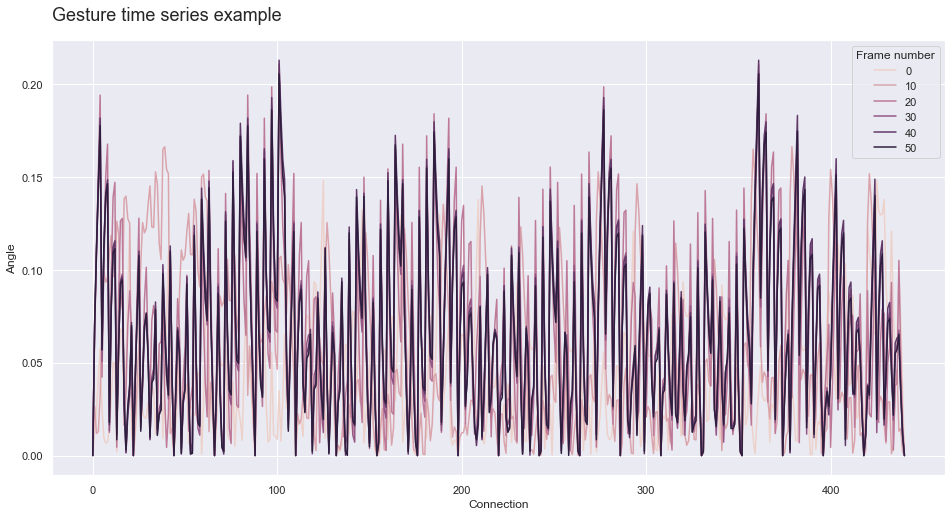

In [171]:
plt.figure(figsize=(16,8))
plt.title('Gesture time series example', size=18, pad=20, loc='left')
sns.lineplot(data=plot_data, x='Connection', y='Angle', hue='Frame')
plt.legend(title='Frame number');

## Read reference Sign

### Read frames from video file

In [172]:
def get_video_frames(file_name):
    
    frame_list = []
    cap = cv2.VideoCapture(file_name)
    pbar = tqdm(desc='Reading frames', total=cap.get(cv2.CAP_PROP_FRAME_COUNT), colour='#f5b324')
    while cap.isOpened():
        # Read frame
        ret, frame = cap.read()
        if not ret:
            pbar.close()
            break
        # Store frame
        frame_list.append(frame)
        pbar.update(1)
    cap.release()
    
    return frame_list

In [180]:
frame_list = get_video_frames('database/Alfabeto/11-Libras - J.mp4')

Reading frames:   0%|          | 0/107.0 [00:00<?, ?it/s]

### Process frames with MediaPipe Hands

In [181]:
hands = mp_hands.Hands(model_complexity=0, 
                       min_detection_confidence=0.5, 
                       min_tracking_confidence=0.9)
results_list = []

for frame in tqdm(frame_list, desc='Detecting hands', total=len(frame_list)):
    results_list.append(hands.process(frame))

Detecting hands:   0%|          | 0/107 [00:00<?, ?it/s]

### Get gesture arrays

In [256]:
def process_landmarks(landmarks_results, verbose=False):
    left_hand_gesture   = None
    left_hand_distance  = None
    right_hand_gesture  = None
    right_hand_distance = None
    # Process results
    left_hand_list, right_hand_list = process_results(landmarks_results, verbose)
    # Create gesture/distance arrays
    if len(left_hand_list)>0:
        left_hand_gesture, left_hand_distance  = create_hand_gesture(left_hand_list, hand_label='left')
    if len(right_hand_list)>0:
        right_hand_gesture, right_hand_distance  = create_hand_gesture(right_hand_list, hand_label='right')
    
    return left_hand_gesture, left_hand_distance, right_hand_gesture, right_hand_distance

In [289]:
left_ref_gest, left_ref_dist, right_ref_gest, right_ref_dist = process_landmarks(results_list, True)

Frames detected:
Left hand:54, Right hand:0


Calculating left landmark angles/distances:   0%|          | 0/54 [00:00<?, ?it/s]

## Compute DTW distance

Basic usage of **fastdtw** 
```
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])

distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
```

Check the distance between the recorded hand on webcam and the respective `reference_left_hand_gesture` (database video)

In [310]:
distance, _ = fastdtw(left_hand_gesture, left_ref_gest, dist=euclidean)
distance

61.444970353640734

In [299]:
# def calculate_dtw(left_test, right_test, left_true, right_true, dist=None):
#     if isinstance(left_test, np.ndarray):
#         if isinstance(left_true, np.ndarray):
#             left_dtw_1, _  = fastdtw(left_test, left_true, dist=dist)
#         else:
#             left_dtw_1 = np.inf
#         if isinstance(right_true, np.ndarray):
#             left_dtw_2, _  = fastdtw(left_test, right_true, dist=dist)
#         else:
#             left_dtw_2 = np.inf
#     else:
#         left_dtw_1, left_dtw_2 = np.inf, np.inf

#     if isinstance(right_test, np.ndarray):
#         if isinstance(left_true, np.ndarray):
#             right_dtw_1, _  = fastdtw(right_test, left_true, dist=dist)
#         else:
#             right_dtw_1 = np.inf
#         if isinstance(right_true, np.ndarray):
#             right_dtw_2, _  = fastdtw(right_test, right_true, dist=dist)
#         else:
#             right_dtw_2 = np.inf
#     else:
#         right_dtw_1, right_dtw_2 = np.inf, np.inf


#     return min(left_dtw_1, left_dtw_2, right_dtw_1, right_dtw_2)

# Compare with sign references

*Database source:* <a href='https://www.youtube.com/user/incluirtecnologia/playlists'>Youtube channel Incluir Tecnologia</a>  
Data previously processed in `/src/reference_database.ipynb`

In [ ]:
# Load references
with open('database/reference_signs_2.pickle', 'rb') as file:
    reference_signs = pickle.load(file)

Angle distance:

In [392]:
angle_predictions = {}
for letter, sign in reference_signs.items():
    dist, _ = fastdtw(left_hand_gesture, 
                      sign['angles'], 
                      dist=euclidean)
    print(f'Distance(angles) for sign {letter}: {dist:.2f}')
    angle_predictions[letter] = dist

Distance(angles) for sign A: 77.14
Distance(angles) for sign B: 64.37
Distance(angles) for sign C: 71.62
Distance(angles) for sign Ç: 78.34
Distance(angles) for sign D: 69.14
Distance(angles) for sign E: 66.86
Distance(angles) for sign F: 72.36
Distance(angles) for sign G: 70.53
Distance(angles) for sign H: 72.42
Distance(angles) for sign I: 72.98
Distance(angles) for sign J: 62.76
Distance(angles) for sign K: 71.12
Distance(angles) for sign L: 69.54
Distance(angles) for sign M: 75.17
Distance(angles) for sign N: 78.96


In [368]:
#reference_signs['J']['distance']

In [400]:
fingertip_predictions = {}
for letter, sign in reference_signs.items():
    dist, _ = fastdtw(left_hand_distance, 
                      sign['distance'], 
                      dist=euclidean)
    print(f'Distance(fingertip) for sign {letter}: {dist:.2f}')
    fingertip_predictions[letter] = dist

Distance(fingertip) for sign A: 24.31
Distance(fingertip) for sign B: 22.07
Distance(fingertip) for sign C: 19.59
Distance(fingertip) for sign Ç: 19.71
Distance(fingertip) for sign D: 24.62
Distance(fingertip) for sign E: 20.51
Distance(fingertip) for sign F: 18.99
Distance(fingertip) for sign G: 25.44
Distance(fingertip) for sign H: 25.82
Distance(fingertip) for sign I: 18.47
Distance(fingertip) for sign J: 19.47
Distance(fingertip) for sign K: 26.53
Distance(fingertip) for sign L: 24.17
Distance(fingertip) for sign M: 20.33
Distance(fingertip) for sign N: 22.39


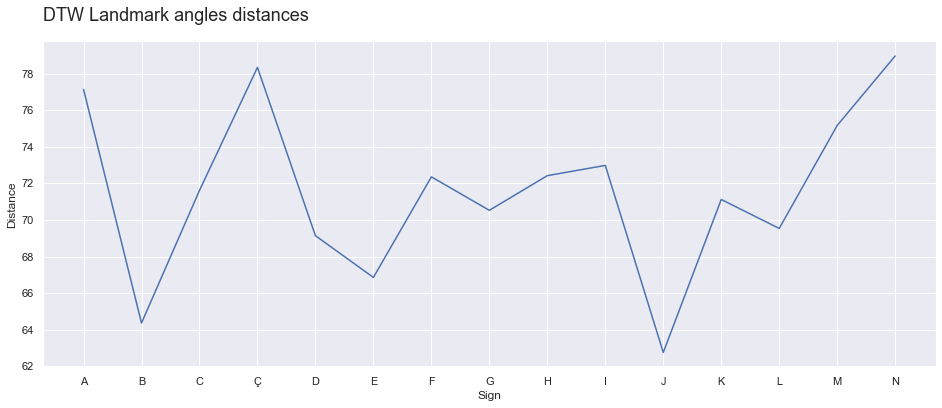

In [402]:
fig = plt.figure(figsize=(16,6))
plt.title('DTW Landmark angles distances', size=18, pad=20, loc='left')
plt.xlabel('Sign')
plt.ylabel('Distance')
sns.lineplot(angle_predictions.keys(), angle_predictions.values());

Get the lowest value from predictions

In [406]:
sorted(angle_predictions, key=angle_predictions.get)

['J', 'B', 'E', 'D', 'L', 'G', 'K', 'C', 'F', 'H', 'I', 'M', 'A', 'Ç', 'N']

In [407]:
sorted(fingertip_predictions, key=fingertip_predictions.get)

['I', 'F', 'J', 'C', 'Ç', 'M', 'E', 'B', 'N', 'L', 'A', 'D', 'G', 'H', 'K']

In [414]:
def find_best_candidate(angle_predictions, fingertip_predictions, threshold=3):
    
    angle_rank = sorted(angle_predictions, key=angle_predictions.get)[:threshold]
    fingertip_rank = sorted(fingertip_predictions, key=fingertip_predictions.get)[:threshold]
    
    for i in range(threshold):
        for j in range(threshold):
            if angle_rank[i] in fingertip_rank[j]:
                return angle_rank[i]
    return 'None'
    
find_best_candidate(angle_predictions, fingertip_predictions)

'J'

In [417]:
tuple(reversed((0,50,250)))

(250, 50, 0)

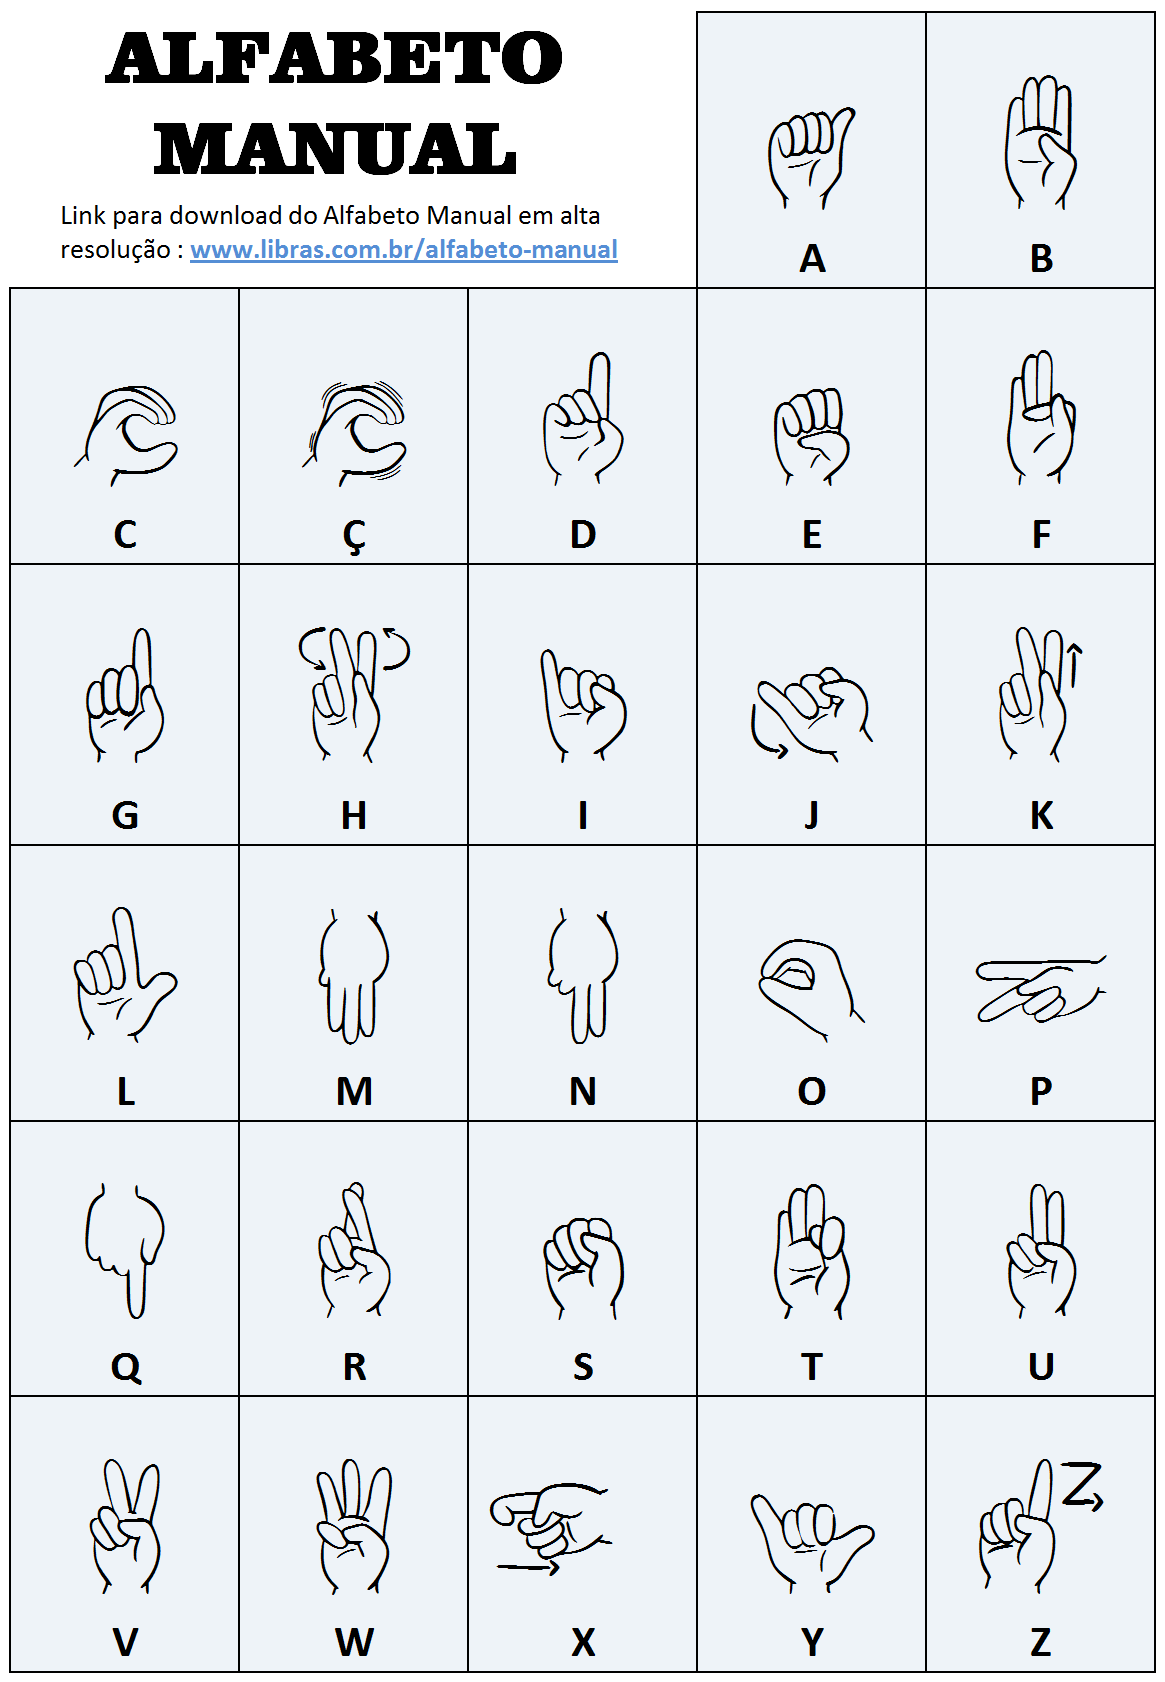

In [189]:
Image('https://www.libras.com.br/images/artigos/alfabeto-manual/alfabeto-manual.png', width=600, height=600)

Best detected letters: B, G, L, C, M, K, F, I, A
Most "overffited" letters: C, I

# Conclusions